In [1]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [11]:
# Toy problem data
input_size = 256  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 256  
sequence_length = 100  # number of sequences/ number of rows
batch_size = 1
num_epochs = 20000

In [12]:
# importing data

In [13]:
# Load the .mat file
v_data = scipy.io.loadmat('v.mat')
h_data = scipy.io.loadmat('h.mat')
x_data = scipy.io.loadmat('x.mat')
x_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Thu Jul 20 15:02:48 2023',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-5.        , -4.96078431, -4.92156863, ...,  4.92156863,
          4.96078431,  5.        ],
        [-5.        , -4.96078431, -4.92156863, ...,  4.92156863,
          4.96078431,  5.        ],
        [-5.        , -4.96078431, -4.92156863, ...,  4.92156863,
          4.96078431,  5.        ],
        ...,
        [-5.        , -4.96078431, -4.92156863, ...,  4.92156863,
          4.96078431,  5.        ],
        [-5.        , -4.96078431, -4.92156863, ...,  4.92156863,
          4.96078431,  5.        ],
        [-5.        , -4.96078431, -4.92156863, ...,  4.92156863,
          4.96078431,  5.        ]])}

In [14]:
x = x_data['X']
u = h_data['h']

In [15]:
print(x.shape)
print(u.shape)

(201, 256)
(201, 256)


In [16]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [17]:
input_data = u[0:100,:]
target_data = u[1:101, :]

test_data = u[101:200, :]
test_target = u[102:201, :]

print("test data shape", test_data.shape)
print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (99, 256)
test target shape (99, 256)
input data shape (100, 256)
Target data shape (100, 256)


In [18]:
# Convert data to tensors
input_tensor = torch.tensor(input_data).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 100, 256])
Target tensor shape torch.Size([1, 100, 256])


In [23]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data).view(batch_size, 99, input_size).float()
test_target_tensor = torch.tensor(test_target).view(batch_size, 99, output_size).float()


In [24]:
# Create LEM instance
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.001)



# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}')




/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 100, 256])) that is different to the input size (torch.Size([100, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/20000, Loss: 0.699901
Epoch: 20/20000, Loss: 0.661521
Epoch: 30/20000, Loss: 0.621066
Epoch: 40/20000, Loss: 0.580986
Epoch: 50/20000, Loss: 0.543069
Epoch: 60/20000, Loss: 0.508558
Epoch: 70/20000, Loss: 0.476130
Epoch: 80/20000, Loss: 0.444360
Epoch: 90/20000, Loss: 0.411983
Epoch: 100/20000, Loss: 0.382273
Epoch: 110/20000, Loss: 0.356296
Epoch: 120/20000, Loss: 0.333132
Epoch: 130/20000, Loss: 0.312232
Epoch: 140/20000, Loss: 0.293205
Epoch: 150/20000, Loss: 0.275766
Epoch: 160/20000, Loss: 0.259698
Epoch: 170/20000, Loss: 0.244833
Epoch: 180/20000, Loss: 0.231039
Epoch: 190/20000, Loss: 0.218207
Epoch: 200/20000, Loss: 0.206246
Epoch: 210/20000, Loss: 0.195078
Epoch: 220/20000, Loss: 0.184637
Epoch: 230/20000, Loss: 0.174863
Epoch: 240/20000, Loss: 0.165706
Epoch: 250/20000, Loss: 0.157120
Epoch: 260/20000, Loss: 0.149062
Epoch: 270/20000, Loss: 0.141495
Epoch: 280/20000, Loss: 0.134387
Epoch: 290/20000, Loss: 0.127706
Epoch: 300/20000, Loss: 0.121425
Epoch: 310/20000, L

Epoch: 2500/20000, Loss: 0.012843
Epoch: 2510/20000, Loss: 0.012790
Epoch: 2520/20000, Loss: 0.012736
Epoch: 2530/20000, Loss: 0.012683
Epoch: 2540/20000, Loss: 0.012630
Epoch: 2550/20000, Loss: 0.012576
Epoch: 2560/20000, Loss: 0.012523
Epoch: 2570/20000, Loss: 0.012470
Epoch: 2580/20000, Loss: 0.012417
Epoch: 2590/20000, Loss: 0.012364
Epoch: 2600/20000, Loss: 0.012310
Epoch: 2610/20000, Loss: 0.012257
Epoch: 2620/20000, Loss: 0.012203
Epoch: 2630/20000, Loss: 0.012149
Epoch: 2640/20000, Loss: 0.012094
Epoch: 2650/20000, Loss: 0.012039
Epoch: 2660/20000, Loss: 0.011984
Epoch: 2670/20000, Loss: 0.011928
Epoch: 2680/20000, Loss: 0.011871
Epoch: 2690/20000, Loss: 0.011813
Epoch: 2700/20000, Loss: 0.011755
Epoch: 2710/20000, Loss: 0.011695
Epoch: 2720/20000, Loss: 0.011634
Epoch: 2730/20000, Loss: 0.011572
Epoch: 2740/20000, Loss: 0.011509
Epoch: 2750/20000, Loss: 0.011444
Epoch: 2760/20000, Loss: 0.011377
Epoch: 2770/20000, Loss: 0.011309
Epoch: 2780/20000, Loss: 0.011240
Epoch: 2790/20

Epoch: 4970/20000, Loss: 0.000441
Epoch: 4980/20000, Loss: 0.000434
Epoch: 4990/20000, Loss: 0.000428
Epoch: 5000/20000, Loss: 0.000422
Epoch: 5010/20000, Loss: 0.000416
Epoch: 5020/20000, Loss: 0.000410
Epoch: 5030/20000, Loss: 0.000404
Epoch: 5040/20000, Loss: 0.000398
Epoch: 5050/20000, Loss: 0.000393
Epoch: 5060/20000, Loss: 0.000387
Epoch: 5070/20000, Loss: 0.000382
Epoch: 5080/20000, Loss: 0.000376
Epoch: 5090/20000, Loss: 0.000371
Epoch: 5100/20000, Loss: 0.000371
Epoch: 5110/20000, Loss: 0.000362
Epoch: 5120/20000, Loss: 0.000355
Epoch: 5130/20000, Loss: 0.000344
Epoch: 5140/20000, Loss: 0.000336
Epoch: 5150/20000, Loss: 0.000328
Epoch: 5160/20000, Loss: 0.000321
Epoch: 5170/20000, Loss: 0.000315
Epoch: 5180/20000, Loss: 0.000309
Epoch: 5190/20000, Loss: 0.000303
Epoch: 5200/20000, Loss: 0.000297
Epoch: 5210/20000, Loss: 0.000292
Epoch: 5220/20000, Loss: 0.000286
Epoch: 5230/20000, Loss: 0.000281
Epoch: 5240/20000, Loss: 0.000276
Epoch: 5250/20000, Loss: 0.000272
Epoch: 5260/20

Epoch: 7500/20000, Loss: 0.000012
Epoch: 7510/20000, Loss: 0.000012
Epoch: 7520/20000, Loss: 0.000012
Epoch: 7530/20000, Loss: 0.000011
Epoch: 7540/20000, Loss: 0.000011
Epoch: 7550/20000, Loss: 0.000011
Epoch: 7560/20000, Loss: 0.000011
Epoch: 7570/20000, Loss: 0.000011
Epoch: 7580/20000, Loss: 0.000011
Epoch: 7590/20000, Loss: 0.000011
Epoch: 7600/20000, Loss: 0.000011
Epoch: 7610/20000, Loss: 0.000011
Epoch: 7620/20000, Loss: 0.000011
Epoch: 7630/20000, Loss: 0.000010
Epoch: 7640/20000, Loss: 0.000010
Epoch: 7650/20000, Loss: 0.000010
Epoch: 7660/20000, Loss: 0.000010
Epoch: 7670/20000, Loss: 0.000010
Epoch: 7680/20000, Loss: 0.000010
Epoch: 7690/20000, Loss: 0.000010
Epoch: 7700/20000, Loss: 0.000010
Epoch: 7710/20000, Loss: 0.000010
Epoch: 7720/20000, Loss: 0.000010
Epoch: 7730/20000, Loss: 0.000010
Epoch: 7740/20000, Loss: 0.000017
Epoch: 7750/20000, Loss: 0.000010
Epoch: 7760/20000, Loss: 0.000009
Epoch: 7770/20000, Loss: 0.000009
Epoch: 7780/20000, Loss: 0.000009
Epoch: 7790/20

Epoch: 10050/20000, Loss: 0.000002
Epoch: 10060/20000, Loss: 0.000002
Epoch: 10070/20000, Loss: 0.000002
Epoch: 10080/20000, Loss: 0.000002
Epoch: 10090/20000, Loss: 0.000002
Epoch: 10100/20000, Loss: 0.000002
Epoch: 10110/20000, Loss: 0.000003
Epoch: 10120/20000, Loss: 0.000005
Epoch: 10130/20000, Loss: 0.000002
Epoch: 10140/20000, Loss: 0.000002
Epoch: 10150/20000, Loss: 0.000002
Epoch: 10160/20000, Loss: 0.000002
Epoch: 10170/20000, Loss: 0.000002
Epoch: 10180/20000, Loss: 0.000002
Epoch: 10190/20000, Loss: 0.000002
Epoch: 10200/20000, Loss: 0.000002
Epoch: 10210/20000, Loss: 0.000002
Epoch: 10220/20000, Loss: 0.000002
Epoch: 10230/20000, Loss: 0.000002
Epoch: 10240/20000, Loss: 0.000002
Epoch: 10250/20000, Loss: 0.000002
Epoch: 10260/20000, Loss: 0.000002
Epoch: 10270/20000, Loss: 0.000002
Epoch: 10280/20000, Loss: 0.000002
Epoch: 10290/20000, Loss: 0.000002
Epoch: 10300/20000, Loss: 0.000002
Epoch: 10310/20000, Loss: 0.000004
Epoch: 10320/20000, Loss: 0.000003
Epoch: 10330/20000, 

Epoch: 12450/20000, Loss: 0.000001
Epoch: 12460/20000, Loss: 0.000001
Epoch: 12470/20000, Loss: 0.000001
Epoch: 12480/20000, Loss: 0.000004
Epoch: 12490/20000, Loss: 0.000002
Epoch: 12500/20000, Loss: 0.000002
Epoch: 12510/20000, Loss: 0.000002
Epoch: 12520/20000, Loss: 0.000001
Epoch: 12530/20000, Loss: 0.000001
Epoch: 12540/20000, Loss: 0.000001
Epoch: 12550/20000, Loss: 0.000001
Epoch: 12560/20000, Loss: 0.000001
Epoch: 12570/20000, Loss: 0.000001
Epoch: 12580/20000, Loss: 0.000001
Epoch: 12590/20000, Loss: 0.000001
Epoch: 12600/20000, Loss: 0.000001
Epoch: 12610/20000, Loss: 0.000001
Epoch: 12620/20000, Loss: 0.000001
Epoch: 12630/20000, Loss: 0.000001
Epoch: 12640/20000, Loss: 0.000001
Epoch: 12650/20000, Loss: 0.000001
Epoch: 12660/20000, Loss: 0.000001
Epoch: 12670/20000, Loss: 0.000003
Epoch: 12680/20000, Loss: 0.000001
Epoch: 12690/20000, Loss: 0.000002
Epoch: 12700/20000, Loss: 0.000001
Epoch: 12710/20000, Loss: 0.000001
Epoch: 12720/20000, Loss: 0.000001
Epoch: 12730/20000, 

Epoch: 14940/20000, Loss: 0.000003
Epoch: 14950/20000, Loss: 0.000001
Epoch: 14960/20000, Loss: 0.000001
Epoch: 14970/20000, Loss: 0.000001
Epoch: 14980/20000, Loss: 0.000001
Epoch: 14990/20000, Loss: 0.000001
Epoch: 15000/20000, Loss: 0.000001
Epoch: 15010/20000, Loss: 0.000001
Epoch: 15020/20000, Loss: 0.000001
Epoch: 15030/20000, Loss: 0.000001
Epoch: 15040/20000, Loss: 0.000001
Epoch: 15050/20000, Loss: 0.000001
Epoch: 15060/20000, Loss: 0.000001
Epoch: 15070/20000, Loss: 0.000005
Epoch: 15080/20000, Loss: 0.000003
Epoch: 15090/20000, Loss: 0.000001
Epoch: 15100/20000, Loss: 0.000001
Epoch: 15110/20000, Loss: 0.000001
Epoch: 15120/20000, Loss: 0.000001
Epoch: 15130/20000, Loss: 0.000001
Epoch: 15140/20000, Loss: 0.000001
Epoch: 15150/20000, Loss: 0.000001
Epoch: 15160/20000, Loss: 0.000001
Epoch: 15170/20000, Loss: 0.000001
Epoch: 15180/20000, Loss: 0.000001
Epoch: 15190/20000, Loss: 0.000001
Epoch: 15200/20000, Loss: 0.000001
Epoch: 15210/20000, Loss: 0.000001
Epoch: 15220/20000, 

Epoch: 17500/20000, Loss: 0.000008
Epoch: 17510/20000, Loss: 0.000001
Epoch: 17520/20000, Loss: 0.000001
Epoch: 17530/20000, Loss: 0.000001
Epoch: 17540/20000, Loss: 0.000001
Epoch: 17550/20000, Loss: 0.000001
Epoch: 17560/20000, Loss: 0.000001
Epoch: 17570/20000, Loss: 0.000001
Epoch: 17580/20000, Loss: 0.000001
Epoch: 17590/20000, Loss: 0.000001
Epoch: 17600/20000, Loss: 0.000001
Epoch: 17610/20000, Loss: 0.000001
Epoch: 17620/20000, Loss: 0.000001
Epoch: 17630/20000, Loss: 0.000001
Epoch: 17640/20000, Loss: 0.000001
Epoch: 17650/20000, Loss: 0.000001
Epoch: 17660/20000, Loss: 0.000001
Epoch: 17670/20000, Loss: 0.000001
Epoch: 17680/20000, Loss: 0.000001
Epoch: 17690/20000, Loss: 0.000001
Epoch: 17700/20000, Loss: 0.000001
Epoch: 17710/20000, Loss: 0.000005
Epoch: 17720/20000, Loss: 0.000005
Epoch: 17730/20000, Loss: 0.000002
Epoch: 17740/20000, Loss: 0.000001
Epoch: 17750/20000, Loss: 0.000001
Epoch: 17760/20000, Loss: 0.000001
Epoch: 17770/20000, Loss: 0.000001
Epoch: 17780/20000, 

(1, 256)
(1, 201)
(256, 201)


<Figure size 432x288 with 0 Axes>

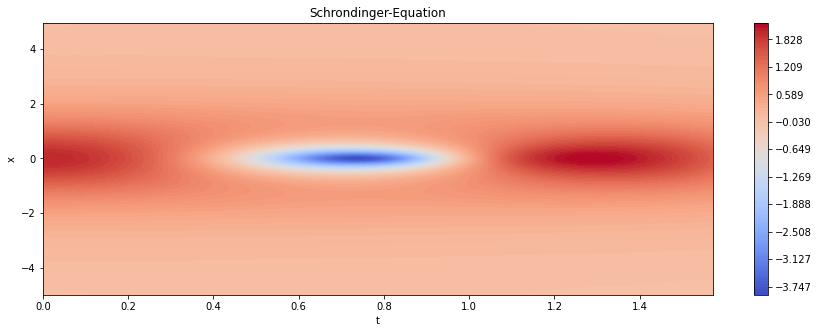

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u), np.max(u), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

torch.Size([99, 256])
torch.Size([256])
(256, 1)
(256, 1)


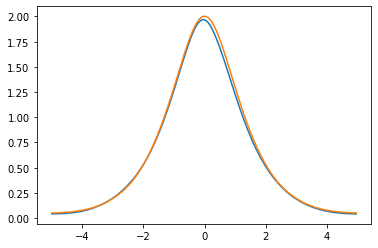

In [26]:
with torch.no_grad():
    prediction = lem(test_tensor)

print(prediction.shape)

final_time_output = prediction[-1, :]
print(final_time_output.shape)

final_out = final_time_output.detach().numpy().reshape(-1,1)
final_true = u[:,-1].reshape(-1,1)

final_true = np.abs(final_true)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()

torch.Size([99, 256])
torch.Size([256])
(256, 1)
(256, 1)


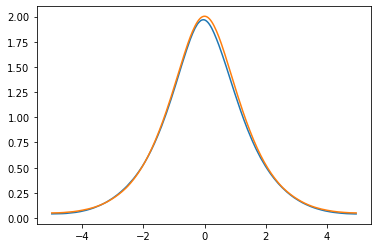

In [27]:

with torch.no_grad():
    prediction = lem(test_tensor)

print(prediction.shape)

final_time_output = prediction[-1, :]
print(final_time_output.shape)

final_out = final_time_output.detach().numpy().reshape(-1,1)
final_true = u[:,-3].reshape(-1,1)

final_true = np.abs(final_true)
#final_out = np.abs(final_out)

print(final_out.shape)
print(final_true.shape)

x = x.reshape(-1, 1)

plt.plot(x, final_out)
plt.plot(x, final_true)
plt.show()


In [28]:
# Convert NumPy arrays to PyTorch tensors
final_out_tensor = torch.from_numpy(final_out)
final_true_tensor = torch.from_numpy(final_true)
final_true_tensor = torch.abs(final_true_tensor)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((final_out_tensor - final_true_tensor)**2)/torch.mean(final_true_tensor**2)
print("Relative Error Test: ", relative_error_test.item(), "")

Relative Error Test:  0.0010676716321293093 
